## Cleaning JSON data

In [12]:
import os
import django

# Set the DJANGO_SETTINGS_MODULE environment variable to your project's settings.
# Adjust the string below to match your project structure; for example, if your settings file is
# located at lucy/backend/settings.py, you would use "lucy.backend.settings".
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'backend.settings')

# Setup Django.
django.setup()

import json
from django.core import serializers
from backend.apps.job_scraping.models import Job

def dump_jobs_to_json(output_file):
    """
    Serializes all Job objects to JSON and writes them to output_file.
    Non-ASCII characters are preserved (not escaped) by using ensure_ascii=False.
    """
    # Serialize all Job objects with indentation for readability.
    data = serializers.serialize("json", Job.objects.all(), indent=4)
    # Convert the JSON string back into a Python object.
    obj = json.loads(data)
    # Write out the data with UTF-8 encoding and ensure_ascii=False
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=4)

if __name__ == "__main__":
    output_file = "jobs.json"
    dump_jobs_to_json(output_file)
    print(f"Jobs have been dumped to {output_file}")


ImproperlyConfigured: Requested setting INSTALLED_APPS, but settings are not configured. You must either define the environment variable DJANGO_SETTINGS_MODULE or call settings.configure() before accessing settings.

In [14]:
import json

def clean_jobs_json(input_file, output_file):
    """
    Reads a JSON fixture file (dumped from Django), cleans the numeric fields so that
    any empty or whitespace-only strings become null (None), and writes the cleaned data
    to a new JSON file.
    """
    # Open the input file using utf-8-sig in case there's a BOM.
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # List of field names that should be integers.
    int_fields = ['industry', 'regionID', 'employmentPositionIds', 'employmentTypeIds', 'company_id']
    
    for record in data:
        fields = record.get('fields', {})
        for field in int_fields:
            if field in fields:
                value = fields[field]
                # If value is a string, strip whitespace.
                if isinstance(value, str):
                    value_stripped = value.strip()
                    if value_stripped == "":
                        fields[field] = None
                    else:
                        try:
                            fields[field] = int(value_stripped)
                        except ValueError:
                            # If conversion fails, set it to None.
                            fields[field] = None
                # If it is not a string, leave it as is.
        record['fields'] = fields

    # Write the cleaned data back out.
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4)

if __name__ == "__main__":
    input_file = 'jobs.json'
    output_file = 'jobs_clean.json'
    clean_jobs_json(input_file, output_file)
    print(f"Cleaned data has been written to {output_file}")


Cleaned data has been written to jobs_clean.json


In [3]:
import chardet

with open(input_file, 'rb') as f:
    rawdata = f.read(10000)  # Read first 10KB for detection
    result = chardet.detect(rawdata)
    print(result)


{'encoding': 'UTF-16', 'confidence': 1.0, 'language': ''}


## Setting Up Logging on Telegram

In [1]:
bot_id = '@LucyErrorLogging_bot'
chat_id = '6025675602'

import requests

send = requests.get(f'https://api.telegram.org/bot{bot_id}/sendMessage?chat_id={chat_id}&text=Hello%20World')

In [2]:
send

<Response [404]>

In [1]:
import logging
from config.logging_config import setup_logging

def test_logging():
    logging.error("Test error message: This should trigger a Telegram notification.")

if __name__ == "__main__":
    setup_logging()
    test_logging()


2025-02-01 19:56:39,244 - DEBUG - [setup_logging] Telegram handler added successfully.
2025-02-01 19:56:39,253 - ERROR - Test error message: This should trigger a Telegram notification.
2025-02-01 19:56:39,255 - DEBUG - Starting new HTTPS connection (1): api.telegram.org:443
2025-02-01 19:56:39,407 - DEBUG - https://api.telegram.org:443 "POST /bot7811065227:AAH21yy1_DPiC4NDFlIgT0gh8znhgGqbDNY/sendMessage HTTP/11" 200 331


## Fixing jobup

In [1]:
from src.job_scraping.jobs_functions import *
from config.logging_config import setup_logging

setup_logging()

job_links = get_links(1, 1)

2025-01-29 21:43:32,865 - DEBUG - Starting new HTTPS connection (1): www.jobup.ch:443
2025-01-29 21:43:33,230 - DEBUG - https://www.jobup.ch:443 "GET /en/jobs/?page=1&publication-date=1&region=33&region=34&region=40&region=42&region=52&region=57&term= HTTP/11" 200 None


In [2]:
job_links[0]

'https://www.jobup.ch/en/jobs/detail/4eb73bd8-4e6d-434f-862e-aea8dbe5d3c0/?source=vacancy_search'

In [3]:
react_query_state = get_job_info(job_links[0])

2025-01-29 21:43:42,574 - INFO - [GET_JOB_INFO] Starting job info extraction for link: https://www.jobup.ch/en/jobs/detail/4eb73bd8-4e6d-434f-862e-aea8dbe5d3c0/?source=vacancy_search
2025-01-29 21:43:42,583 - DEBUG - Starting new HTTPS connection (1): www.jobup.ch:443
2025-01-29 21:43:42,958 - DEBUG - https://www.jobup.ch:443 "GET /en/jobs/detail/4eb73bd8-4e6d-434f-862e-aea8dbe5d3c0/?source=vacancy_search HTTP/11" 200 None
2025-01-29 21:43:42,969 - INFO - [GET_JOB_INFO] Successfully fetched page with status code 200 for link: https://www.jobup.ch/en/jobs/detail/4eb73bd8-4e6d-434f-862e-aea8dbe5d3c0/?source=vacancy_search
2025-01-29 21:43:42,992 - INFO - [GET_JOB_INFO] Found script containing __REACT_QUERY_STATE__.
2025-01-29 21:43:42,992 - INFO - [GET_JOB_INFO] Successfully parsed __REACT_QUERY_STATE__ for link: https://www.jobup.ch/en/jobs/detail/4eb73bd8-4e6d-434f-862e-aea8dbe5d3c0/?source=vacancy_search


In [4]:
react_query_state

{'mutations': [],
 'queries': [{'state': {'data': {'applicationOptions': {'isApplicationMethodOnline': False,
      'method': 'APPLICATION_METHOD.EXTERNAL',
      'externalUrl': 'https://nestle-operational-services-worldwide-sa.contactrh.com/jobs/5040/43137450'},
     'logo': 'https://media.jobup.ch/media/b2dafc16-68ce-4b87-a8b3-7414999efc0a.jpg?dimensions=320x0',
     'mood': None,
     'bookmarkId': None,
     'benefits': [],
     'categories': [{'path': '/686/687',
       'lvl_0': '686',
       'lvl_1': '687',
       'root': '686'}],
     'company': {'city': None,
      'companyLogoFile': None,
      'id': '4091',
      'logoImage': {'src': 'https://media.jobup.ch/media/b2dafc16-68ce-4b87-a8b3-7414999efc0a.jpg?dimensions=320x0',
       'height': 44,
       'width': 124},
      'name': 'Nestlé Operational Services Worldwide SA',
      'slug': '4091-nestle-operational-services-worldwide-sa',
      'visible': True,
      'website': None},
     'contacts': [{'recipient': 'kW9axe7Q42a7oc

# To print file structure

In [5]:
import os

def print_directory_structure(path, indent=0):
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        print(' ' * indent + f'├── {item}')
        if os.path.isdir(item_path):
            print_directory_structure(item_path, indent + 4)

# Specify the root path of your project
project_path = r'C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy'
print(f'File structure for: {project_path}')

print_directory_structure(project_path)

File structure for: C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy
├── .env
├── config
    ├── settings.py
    ├── __init__.py
    ├── __pycache__
        ├── settings.cpython-311.pyc
        ├── __init__.cpython-311.pyc
├── data
    ├── identifiers.db
    ├── jobs.db
├── docs
    ├── README.md
├── research-assistant.ipynb
├── scratchpad.ipynb
├── scripts
    ├── scraping
        ├── get_industries.py
        ├── scrape_jobs.py
    ├── __init__.py
├── src
    ├── data_processing
        ├── process_documents.py
        ├── __pycache__
            ├── process_documents.cpython-311.pyc
    ├── helpers
        ├── helper_functions.py
        ├── __pycache__
            ├── helper_functions.cpython-311.pyc
    ├── job_scraping
        ├── indentifiers_functions.py
        ├── jobs_functions.py
        ├── __init__.py
    ├── __init__.py
├── test.py
├── user_docs
    ├── test.docx
    ├── TK_CoverLetter.docx
    ├── TK_CoverLetter.pdf
    ├── TK_CV_2024.docx
    ├── TK_CV_202

# Working with SQLITE

In [13]:
import sqlite3 
from config.settings import DATABASES

employement_position_id = {
    "1": "executive_position",
    "2": "position_with_responsibilities",
    "3": "employee",
}

employement_type_id = {
    "1": "temporary",
    "2": "freelance",
    "3": "internship",
    "4": "supplementary_income",
    "5": "permanent_position",
    "6": "apprenticeship",
}

In [6]:
conn = sqlite3.connect(DATABASES['identifiers'])
cursor = conn.cursor()

In [14]:
cursor.execute("CREATE TABLE employement_position_id (id INTEGER PRIMARY KEY, name TEXT)")
for key, value in employement_position_id.items():
    cursor.execute("INSERT INTO employement_position_id (name) VALUES (?)", (value,))
conn.commit()

cursor.execute("CREATE TABLE employement_type_id (id INTEGER PRIMARY KEY, name TEXT)")
for key, value in employement_type_id.items():
    cursor.execute("INSERT INTO employement_type_id (name) VALUES (?)", (value,))

In [12]:
cursor.execute("SELECT * FROM employement_position_id")
cursor.fetchall()

[(1, 'executive_position'),
 (2, 'position_with_responsibilities'),
 (3, 'employee')]

In [11]:
cursor.execute("SELECT * FROM employement_type_id")
cursor.fetchall()

[(1, 'temporary'),
 (2, 'freelance'),
 (3, 'internship'),
 (4, 'supplementary_income'),
 (5, 'permanent_position'),
 (6, 'apprenticeship')]

In [10]:
cursor.execute("SELECT * FROM industries") ##where lang = 'EN'")
cursor.fetchall()

[(1,
  'FR',
  "Construction d'installations / de machines et construction métallique"),
 (1, 'EN', 'Plant / Machine / Metal construction'),
 (2, 'FR', 'Aéronautique / Logistique / Transport / Mobilité'),
 (2, 'EN', 'Aviation / Logistics / Transport / Traffic'),
 (3, 'FR', 'Banques'),
 (3, 'EN', 'Banking'),
 (4, 'FR', 'Bâtiment / Immobilier'),
 (4, 'EN', 'Construction industry / Real estate'),
 (5, 'FR', 'Vêtements / Textile'),
 (5, 'EN', 'Clothing / Textiles'),
 (6, 'FR', 'Enseignement'),
 (6, 'EN', 'Education system'),
 (7, 'FR', 'Biotechnologie / Chimie / Pharmaceutique'),
 (7, 'EN', 'Biotechnology / Chemistry / Pharmaceutical'),
 (8, 'FR', 'Commerce de détail'),
 (8, 'EN', 'Retail business'),
 (9, 'FR', 'Services'),
 (9, 'EN', 'Services'),
 (10, 'FR', 'E-business / Internet'),
 (10, 'EN', 'E-business / Internet'),
 (11, 'FR', 'Electronique / Electrotechnique'),
 (11, 'EN', 'Electronics / Electrotechnical'),
 (12, 'FR', 'Alimentation en énergie / en eau'),
 (12, 'EN', 'Power / Water

In [17]:
conn.commit()

In [24]:
conn.close()

In [21]:
## See all tables in a database
query="""
 SELECT name FROM sqlite_master WHERE type='table';
 """

#conn = sqlite3.connect(DATABASES['jobs'])
#cursor = conn.cursor()
cursor.execute(query).fetchall()

[('job_info',),
 ('django_migrations',),
 ('sqlite_sequence',),
 ('auth_group_permissions',),
 ('auth_user_groups',),
 ('auth_user_user_permissions',),
 ('django_admin_log',),
 ('django_content_type',),
 ('auth_permission',),
 ('auth_group',),
 ('auth_user',),
 ('django_session',),
 ('jobs',)]

In [4]:
cursor.execute("UPDATE jobs SET industry = NULL WHERE industry = '';")

In [16]:
import sqlite3
from config.settings import DATABASES
conn = sqlite3.connect(DATABASES['jobs'])
cursor = conn.cursor()

In [13]:
#cursor.execute('PRAGMA table_info(jobs)').fetchall()
#cursor.execute("select industry from jobs where industry=''").fetchall()
cursor.execute("select count(*) from jobs where industry='';").fetchall()

[(0,)]

In [17]:
cursor.execute("select * from jobs limit 10").fetchall()

[('e4d0b130-1877-4dd0-989f-83696b815f36',
  'https://careers.dentsplysirona.com/job/Ballaigues-Ing%C3%A9nieur-automaticien-Ballaigues%2C-Suisse-1338/1113748701/',
  'https://media.jobs.ch/images/bbf96078-4c26-4de8-90d5-28dc617b2915/124x44.png',
  None,
  'Dentsply Sirona',
  '',
  '',
  1,
  '2024-12-27T16:02:21+01:00',
  1,
  0,
  '',
  '',
  'Ballaigues',
  '',
  '',
  '2024-12-27T16:02:21+01:00',
  '2026-01-01',
  '',
  'Automation Engineer',
  'None',
  'Ingénieur automaticien - Ballaigues, Suisse',
  31,
  54,
  None,
  None,
  None),
 ('9aad45ef-3ee3-4aa1-8d56-1caf51f02cd4',
  'https://sunrise.wd3.myworkdayjobs.com/Sunrise/job/Swiss-Romandie/Sales-Agent-Genve-Rue-de-Rive--f-m-d--80-_REQ_30035239-1/apply',
  'https://media.jobs.ch/images/492842ea-2f31-4e1b-847c-cd44c584c6eb/320x320.png',
  None,
  'Sunrise GmbH',
  '',
  '',
  1,
  '2024-12-27T15:02:35+01:00',
  1,
  0,
  'fr (Level 2)',
  '',
  'Genève',
  '',
  '',
  '2024-12-27T15:02:35+01:00',
  '2026-01-01',
  '',
  'Account 

In [5]:
conn.commit()

In [18]:
cursor.close()
conn.close()


In [14]:
from config.settings import DATABASES
import sqlite3

def get_scraped_links():
    scraped_links = set()

    conn = sqlite3.connect(DATABASES['jobs'])
    cursor = conn.cursor()

    cursor.execute("SELECT id FROM jobs")
    id_list = [row[0] for row in cursor.fetchall()]

    for id in id_list:
        link = f"https://www.jobup.ch/en/jobs/detail/{id}/?source=vacancy_search"
        scraped_links.add(link)
    
    conn.close()
    
    return scraped_links  

In [22]:
cursor.execute("SELECT count(*) FROM jobs")
cursor.fetchall()

[(7109,)]

In [25]:
cursor.execute("SELECT count(*) FROM job_scraping_job")
cursor.fetchall()

[(114,)]

In [26]:
cursor.execute("DROP TABLE job_scraping_job")

In [3]:
import sqlite3
from config.settings import DATABASES
import requests
from urllib.parse import urlparse
import logging
import os
from config.logging_config import setup_logging

setup_logging()

def get_ids_to_delete(sqlite_path=DATABASES['jobs']):
    """
    Identifies and logs invalid job posting URLs in a SQLite database, with fallback mechanisms for handling SSL errors
    and retrying using a secondary URL.

    This function checks the validity of job posting URLs stored in a SQLite database. It performs the following steps:

    1. **Fetch IDs and URLs**: Retrieves all job IDs and corresponding URLs from the database.
    2. **Validation and Logging**:
       - Checks if the URL is valid (non-empty and has a valid scheme like http or https).
       - Logs invalid or empty URLs as warnings.
    3. **Fallback Mechanism**:
       - For invalid URLs, attempts to construct and validate a fallback URL for the `jobup` platform.
       - Logs the result of the fallback URL validation.
    4. **SSL Error Handling**:
       - For URLs that raise an SSL certificate verification error, retries the request with SSL verification disabled (`verify=False`).
       - Logs both the occurrence of the SSL error and the result of the retry.
    5. **Error Handling**:
       - Handles and logs other request errors (e.g., timeouts, connection errors) that occur during URL validation.

    Logging Details:
    - **INFO**:
      - Logs valid URLs that successfully respond with status codes below 400.
      - Logs valid fallback URLs when the primary URL is invalid or empty.
    - **WARNING**:
      - Logs invalid URLs (status codes 400 or above).
      - Logs fallback URL failures.
      - Logs when retrying with `verify=False` for SSL errors.
    - **ERROR**:
      - Logs errors during URL validation, including SSL errors and general request exceptions.

    Parameters:
    ----------
    sqlite_path : str, optional
        The file path to the SQLite database containing the job postings. Defaults to the `jobs` database in `DATABASES`.

    Returns:
    -------
    list
        A list of job IDs corresponding to invalid or unreachable URLs.

    Example:
    -------
    >>> ids_to_delete = get_ids_to_delete()
    >>> print(ids_to_delete)
    ["job_id_1", "job_id_2", ...]
    """
        
    conn = sqlite3.connect(sqlite_path)
    cursor = conn.cursor()

    # Fetch all IDs and URLs from the database
    cursor.execute("SELECT id, externalUrl FROM jobs")
    ids_and_links = cursor.fetchall()
    conn.close()

    ids_to_delete = []

    for job_id, link in ids_and_links:
        try:
            # Skip invalid or empty URLs
            if not link or not urlparse(link).scheme:
                logging.warning(f"Invalid URL detected: ID={job_id}, URL='{link}'")
                
                # Try the fallback Jobup URL
                jobup_link = f"https://www.jobup.ch/en/jobs/detail/{job_id}/?source=vacancy_search"
                try:
                    response = requests.head(jobup_link, timeout=5)
                    if response.status_code < 400:
                        logging.info(f"Fallback link is valid: ID={job_id}, URL={jobup_link}")
                        continue  # Skip to the next job since the fallback worked
                    else:
                        logging.warning(f"Fallback link is invalid: ID={job_id}, URL={jobup_link}, Status Code={response.status_code}")
                        ids_to_delete.append(job_id)
                except requests.RequestException as e:
                    logging.error(f"Error checking fallback URL: ID={job_id}, URL={jobup_link}, Error={e}")
                    ids_to_delete.append(job_id)
                continue  # Move to the next job after handling the fallback

            # Check the original link with a HEAD request
            try:
                response = requests.head(link, timeout=5)
                if response.status_code < 400:
                    logging.info(f"Link is valid: ID={job_id}, URL={link}")
                else:
                    logging.warning(f"Invalid link: ID={job_id}, URL={link}, Status Code={response.status_code}")
                    ids_to_delete.append(job_id)

            except requests.exceptions.SSLError as ssl_error:
                logging.warning(f"SSL error for URL: {link}, attempting with verify=False. Error: {ssl_error}")
                try:
                    # Retry with SSL verification disabled
                    response = requests.head(link, timeout=5, verify=False)
                    if response.status_code < 400:
                        logging.info(f"Link is valid with verify=False: ID={job_id}, URL={link}")
                    else:
                        logging.warning(f"Invalid link even with verify=False: ID={job_id}, URL={link}, Status Code={response.status_code}")
                        ids_to_delete.append(job_id)
                except requests.RequestException as e:
                    logging.error(f"Error checking URL with verify=False: ID={job_id}, URL={link}, Error={e}")
                    ids_to_delete.append(job_id)

        except requests.RequestException as e:
            # Log the error and add the ID to the deletion list
            logging.error(f"Error checking original URL: ID={job_id}, URL={link}, Error={e}")
            ids_to_delete.append(job_id)

    return ids_to_delete


def clean_database():
    ids_to_delete = get_ids_to_delete()

    conn = sqlite3.connect(DATABASES['jobs'])
    cursor = conn.cursor()

    try:
        placeholders = ','.join(['?'] * len(ids_to_delete))
        query = f"DELETE FROM jobs WHERE id IN ({placeholders})"
        cursor.execute(query, ids_to_delete)
        conn.commit()
        print(f"Deleted {cursor.rowcount} rows from the table.")
    except sqlite3.Error as e:
        print(f"An error occurred: {e}")
    finally:
        conn.close()

In [4]:
get_ids_to_delete()

2025-01-26 21:18:52,162 - DEBUG - Starting new HTTPS connection (1): api.easytemp.ch:443
2025-01-26 21:18:52,228 - DEBUG - https://api.easytemp.ch:443 "HEAD /live/bew/15478324751832684600-FR.php HTTP/11" 404 0
2025-01-26 21:18:52,229 - WARNING - Invalid link: ID=532bece1-831a-4cf1-9f36-40085d61a179, URL=https://api.easytemp.ch/live/bew/15478324751832684600-FR.php, Status Code=404
2025-01-26 21:18:52,231 - DEBUG - Starting new HTTPS connection (1): api.easytemp.ch:443
2025-01-26 21:18:52,295 - DEBUG - https://api.easytemp.ch:443 "HEAD /live/bew/10226428721404889370-FR.php HTTP/11" 404 0
2025-01-26 21:18:52,297 - WARNING - Invalid link: ID=289e316a-ba6e-4dcb-81cc-52c67ff204c4, URL=https://api.easytemp.ch/live/bew/10226428721404889370-FR.php, Status Code=404
2025-01-26 21:18:52,299 - DEBUG - Starting new HTTPS connection (1): api.easytemp.ch:443
2025-01-26 21:18:52,344 - DEBUG - https://api.easytemp.ch:443 "HEAD /live/bew/17359799721279192540-FR.php HTTP/11" 404 0
2025-01-26 21:18:52,346 

KeyboardInterrupt: 

In [1]:
import requests
import certifi

url = "https://carrieres.romande-energie.ch/job/view-job.php?id=212&language=fr"

cert_path = certifi.where()

try:
    response = requests.head(url, timeout=5, verify=cert_path)
    print(f"Status Code: {response.status_code}")
except requests.exceptions.SSLError as e:
    print(f"SSL Error: {e}")
except requests.exceptions.RequestException as e:
    print(f"Request Error: {e}")


SSL Error: HTTPSConnectionPool(host='carrieres.romande-energie.ch', port=443): Max retries exceeded with url: /job/view-job.php?id=212&language=fr (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)')))


In [2]:
import requests
print(dir(requests.exceptions))

['BaseHTTPError', 'ChunkedEncodingError', 'CompatJSONDecodeError', 'ConnectTimeout', 'ConnectionError', 'ContentDecodingError', 'FileModeWarning', 'HTTPError', 'InvalidHeader', 'InvalidJSONError', 'InvalidProxyURL', 'InvalidSchema', 'InvalidURL', 'JSONDecodeError', 'MissingSchema', 'ProxyError', 'ReadTimeout', 'RequestException', 'RequestsDependencyWarning', 'RequestsWarning', 'RetryError', 'SSLError', 'StreamConsumedError', 'Timeout', 'TooManyRedirects', 'URLRequired', 'UnrewindableBodyError', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__']


In [1]:
import certifi
print(certifi.where())

c:\Users\TylerKleinbauer\anaconda3\envs\LangGraphTutorial\Lib\site-packages\certifi\cacert.pem


In [5]:
import certifi

with open(certifi.where(), 'r') as f:
    cacert_contents = f.read()

print("carrieres.romande-energie.ch" in cacert_contents)


False


In [6]:
import requests

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

#link = f"https://www.jobup.ch/en/jobs/detail/32338e07-e487-4d7c-b346-bd38cd2e98e7/" #?source=vacancy_search"
link = 'https://tnl2.jometer.com/v2/job?jz=5u3d46a9ca7cc10c9f4843bfc72eb799020c1J4ADIBAAAADQ&utm_source=jobup_slots&utm_medium=jobboard&source=jobup_slots'

response = requests.get(link, headers=headers)

In [7]:
response.status_code

404

In [ ]:
from dotenv import load_dotenv
from langchain_chroma import Chroma
from config.settings import DATABASES
from langchain_openai import OpenAIEmbeddings

load_dotenv()

def clean_chroma_database(job_ids):
    """
    Deletes vector store entries one by one, logging success and failure.

    Parameters:
    ----------
    vector_store : Your vector store object
        The vector store from which to delete entries.
    ids : list[str]
        A list of IDs to delete.

    Returns:
    -------
    None
    """
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

    vector_store = Chroma(
        collection_name="job_ads_embeddings",
        embedding_function=embeddings,
        persist_directory=DATABASES['job_ads_embeddings'],
    )

    for id in job_ids:
        try:
            vector_store.delete(id)
            logging.info(f"[CLEAN_CHROMA_DATABASE] Deleted Chroma ID: {id}")
        except Exception as e:
            logging.error(f"[CLEAN_CHROMA_DATABASE] Error deleting Chroma ID: {id}, Error: {e}")

In [21]:
id = ['9aad45ef-3ee3-4aa1-8d56-1caf51f02cd4']

vector_store.get_by_ids(id)

[Document(id='9aad45ef-3ee3-4aa1-8d56-1caf51f02cd4', metadata={'company_name': 'Sunrise GmbH', 'job_title': 'Sales Agent Genève Rue de Rive (f/m/d) 80%'}, page_content="Sales Agent Genève Rue de Rive (f/m/d) 80% Rejoins une équipe de haut vol!Nous sommes le principal challenger du marché suisse des télécommunications et nous sommes cotés à la Swiss Stock Exchange SIX. Avec plus de cinq millions d'abonné-e-s, Sunrise fournit des services de premier ordre dans les domaines de la téléphonie mobile, de la téléphonie fixe, de l'Internet et du divertissement.Nous proposons un environnement de travail dynamique et international, et nos méthodes ainsi que nos espaces de travail tournés vers le futur font de nous l'un des employeurs les plus attractifs sur le marché suisse. Rejoins notre équipe pour créer avec nous l'avenir numérique.Déploie ton talent: découvre Sunriseici.Vos tâches:Vous êtes tous les jours en contact direct avec la clientèle et vous efforcez de répondre au mieux aux besoins d

In [18]:
vector_store.delete(id)

set()


In [19]:
vector_store.similarity_search('test', k=5)

[]

In [5]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from config.settings import DATABASES

keyword_list= '1. Data Science\n2. Technical Stakeholders\n3. Non-Technical Stakeholders\n4. Communication Skills\n5. Bridging Technical and Non-Technical\n6. Achievements\n7. Result-Oriented\n8. Web Scraping Automation\n9. Dashboard Creation\n10. Quantitative Analysis\n11. Efficiency Improvement\n12. Client Management\n13. Project Management\n14. Prestigious Projects\n15. Academic Distinctions\n16. Academic Honors\n17. Relevant Coursework\n18. Certifications\n19. Professional Experience\n20. Career Aspirations\n21. Long-term Career Goals\n22. Industry-Specific Roles\n23. Company Types\n24. Soft Skills\n25. Technical Skills\n26. Tools Proficiency\n27. Up-to-Date Contact Information\n28. Career Objective\n29. Vision for Career\n30. Data Analysis\n31. Automation\n32. Impactful Results\n33. Stakeholder Engagement\n34. Data-Driven Decision Making\n35. Problem-Solving\n36. Collaboration\n37. Teamwork\n38. Analytical Skills\n39. Research\n40. PhD\n41. Tyler R. Kleinbauer'

def retrieve_id_similarity_search(keyword_list, chroma_path=DATABASES['job_ads_embeddings'], results_to_retrive = 5):
    
    # Initialize the embeddings
    embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

    vector_store = Chroma(
    collection_name="job_ads_embeddings",
    embedding_function=embeddings,
    persist_directory=chroma_path)
    
    results = vector_store.similarity_search_with_relevance_scores(
        keyword_list,
        k=results_to_retrive,
    )
    id_list = []
    for res in results:
        id_list.append(res[0].id)
        #print(res[0].id)
        # print(f"{res[0].metadata['job_title']} - {res[0].metadata['company_name']} \n \n")
        # print(f"{res[0].page_content} \n \n")
        # print(f"score: {res[1]} \n \n")
    
    return id_list

ids = retrieve_id_similarity_search(keyword_list)

print(ids)

['a34c81a8-9210-4b79-a278-8201aa9ec82a', '3003da3a-9e0e-45ae-a042-36025458c29c', 'af3d0f5c-b30f-4981-adff-834d4e37336d', 'bbe4a940-9169-47a7-ad8d-617b59f964b3', '3ee3baca-64dd-48ec-8067-85cc5beac5cf']


In [8]:
import sqlite3
from config.settings import DATABASES

sqlite_path = DATABASES['jobs']

def retrieve_jobs_from_ids(ids):
    # Connect to SQLite
    conn = sqlite3.connect(sqlite_path)
    cursor = conn.cursor()

    # Prepare query
    placeholders = ','.join(['?'] * len(ids))  # Create ?,?,?... based on the number of IDs
    query = f"SELECT id, company_name, template_title, template_lead FROM jobs WHERE id IN ({placeholders})"

    # Fetch jobs that are not yet embedded
    cursor.execute(query, ids)
    all_jobs = cursor.fetchall()

    return all_jobs
    
jobs = retrieve_jobs_from_ids(ids)

print(jobs)

[('3003da3a-9e0e-45ae-a042-36025458c29c', 'Bulgari Horlogerie SA', 'Senior Data Analyst', "In order to strengthen our Data, Business Intelligence, and AI team, we are recruiting our next :\n\nAs a key member of our Data and BI team, you will play a pivotal role in maintaining ongoing Power BI reports and projects while developing new insights that directly impact the business. Your strong analytical skills, combined with a passion for transforming business requirements into actionable insights, will support multiple departments and contribute to the company's success.You will ensure a seamless transition of projects from the previous Senior Data Analyst, while continuously evolving our data reporting landscape. You will collaborate closely with various stakeholders across departments, from High Management to Operations, ensuring the accuracy and efficiency of our data processes.Job responsibilitiesCollect, analyze, and interpret large datasets to provide business insights using Power B

# Filtering results stored in tables based on IDs

In [33]:
def fetch_industries(lang='EN'):
    """
    fetches industries from the database

    Args:
    lang (str): language of the industries to fetch (EN or FR)

    Returns:
    list: list of industries in the table
    """
    
    conn = sqlite3.connect('identifiers.db')
    cursor = conn.cursor()
    cursor.execute(f"SELECT id, name FROM industries where lang = '{lang}'")
    industries = cursor.fetchall()
    conn.close()
    return industries

In [34]:
fetch_industries()

[(1, 'Plant / Machine / Metal construction'),
 (2, 'Aviation / Logistics / Transport / Traffic'),
 (3, 'Banking'),
 (4, 'Construction industry / Real estate'),
 (5, 'Clothing / Textiles'),
 (6, 'Education system'),
 (7, 'Biotechnology / Chemistry / Pharmaceutical'),
 (8, 'Retail business'),
 (9, 'Services'),
 (10, 'E-business / Internet'),
 (11, 'Electronics / Electrotechnical'),
 (12, 'Power / Water supply'),
 (13, 'Waste management / Recycling / Environmental technology'),
 (14, 'Automotive market'),
 (15, 'Precision mechanics / Optics / Watch and clock industry'),
 (16, 'Finance / Accounting'),
 (17, 'Science and research'),
 (18, 'Forestry / Agriculture'),
 (19, 'Leisure / Culture / Sports'),
 (20, 'Catering / Hotel business / Tourism'),
 (21, 'Agri-food industry'),
 (22, 'Healthcare'),
 (23, 'Small and medium-sized industries'),
 (24, 'Glass / Plastic / Paper industry'),
 (25, 'Graphic industry / Media / Publishing'),
 (26, 'Wholesale'),
 (27, 'Human resources / Personnel services

In [35]:
import sqlite3
conn = sqlite3.connect('jobs.db')
cursor = conn.cursor()

In [40]:
from helper_functions import display_table

display_table('jobs', 'jobs.db')

,id,externalUrl,logo,company_id,company_name,contact_firstName,contact_lastName,headhunterApplicationAllowed,initialPublicationDate,isActive,isPaid,language_skills,postalCode,city,cantonCode,countryCode,publicationDate,publicationEndDate,skills,synonym,template_lead,template_title,industry,regionID
0,814e996a-1fcb-4005-9023-37566415cefc,https://www.team.jobs/fr/offres-demplois/postu...,https://media.jobs.ch/images/f705eef4-804b-4ec...,93275,leteam ressources humaines,,,1,2024-12-27T05:32:33+01:00,1,1,,,Vevey,,,2024-12-27T05:32:33+01:00,2026-01-01,,Brick Layer,Votre savoir-faire est votre fierté ?Vous êtes...,Maçon Bâtiment Autonome,4,52
1,bc077c9e-7848-4f5d-92a5-ef2f3c9229f6,https://www.team.jobs/fr/offres-demplois/postu...,https://media.jobs.ch/images/f705eef4-804b-4ec...,93275,leteam ressources humaines,,,1,2024-12-27T02:04:30+01:00,1,1,,,Martigny,,,2024-12-27T02:04:30+01:00,2026-01-01,,Heating Engineer,Mandaté par un de nos clients renommé dans son...,Installateur en chauffage,4,52
2,532bece1-831a-4cf1-9f36-40085d61a179,https://api.easytemp.ch/live/bew/1547832475183...,https://media.jobup.ch/media/186bb985-4e81-437...,14470,OK Job SA,Julie,Lavenu,1,2024-12-27T01:42:18+01:00,1,1,,,,,,2024-12-27T01:42:18+01:00,2024-12-29,,,Nous recrutons pour répondre aux besoins de no...,Maitre d'hôtel - Chef de rang (H/F),,34
3,289e316a-ba6e-4dcb-81cc-52c67ff204c4,https://api.easytemp.ch/live/bew/1022642872140...,https://media.jobup.ch/media/186bb985-4e81-437...,14470,OK Job SA,Virginie,Payen,1,2024-12-27T01:42:18+01:00,1,1,,,,,,2024-12-27T01:42:18+01:00,2024-12-29,,,"Pour le compte de notre client, nous rechercho...",Mécatronicien(ne) Poids Lourd H/F à 100%,14,34
4,c5b448f9-0a20-4c64-b587-c7bdb6b2944c,https://api.easytemp.ch/live/bew/1735979972127...,https://media.jobup.ch/media/186bb985-4e81-437...,14470,OK Job SA,Virginie,Payen,1,2024-12-27T01:42:17+01:00,1,1,,,,,,2024-12-27T01:42:17+01:00,2024-12-29,,,"Pour le compte de notre client, nous rechercho...",Monteur mécanique (itinérant) à 60%,2,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,c5c3f323-1f59-4e9f-897e-7781fd223070,,https://media.jobup.ch/media/66d5e964-f08c-4ed...,23982,Fondation Saphir,Vanessa,Baudois,0,2024-12-28T01:42:21+01:00,1,1,,1462,Yvonand,VD,CH,2024-12-28T01:42:21+01:00,2025-01-07,,,Au sein d’une fondation multi-mission (psychog...,Gestionnaire en intendance (F/H/D) en CDI à 10...,22,52
2084,572e6d56-a0b3-49c2-804f-2d4692a2b3ec,,https://media.jobup.ch/media/bcb51472-7f62-43b...,63781,Qualibroker Romandie SA,Virginie,Celin,0,2024-12-28T01:42:21+01:00,1,1,,1752,Villars-sur-Glâne,FR,CH,2024-12-28T01:42:21+01:00,2025-02-05,,,Le groupe Qualibroker-Swiss Risk & Care est sp...,Responsable Clientèle Entreprises,38,33
2085,951f7de5-3963-4c69-91be-6411224d7c26,https://short.sg/j/52022978,https://media.jobup.ch/media/88040912-65cf-484...,62050,Emil Egger Romandie SA,Loïc,Neto,1,2024-12-19T12:36:31+01:00,1,1,,1580,Avenches,VD,CH,2024-12-19T12:36:31+01:00,2025-01-17,,,EMIL EGGER SA est l'une des principales entrep...,Responsable maintenance & infrastructures,2,54
2086,2944f376-badc-47bb-9164-6762f679ddae,https://www.valjob.digital/apply/annonce/1245/S12,https://valjobgroupe.com/wp-content/uploads/20...,44293,Valjob,Schlatter,Maud,1,2024-12-19T18:13:02+01:00,1,1,,,,,,2024-12-19T18:13:02+01:00,2024-12-30,,,Vous êtes à la recherche d’un nouveau challeng...,Menuisier poseur H/F à 100%,27,40


In [74]:
def filter_jobs(industry_ids: list = list(range(1,100)), employement_type_id: list = [1, 2, 3, 4, 5, 6], employement_position_id: list = [1, 2, 3]) -> list:
    """
    fetches jobs from the database filtered by industry and that are still active

    Args:
    industry_ids (list): list of ids of industries to filter by
    employement_type_id (list): list of ids of employment types to filter by
    employement_position_id (list): list of ids of employment positions to filter by

    Returns:
    list: list of jobs in the table
    """
    
    conn = sqlite3.connect('jobs.db')
    cursor = conn.cursor()
    cursor.execute(f"SELECT * FROM jobs WHERE industry IN ({','.join([str(i) for i in industry_ids])}) AND employmentTypeIds IN ({','.join([str(i) for i in employement_type_id])}) AND employmentPositionIds IN ({','.join([str(i) for i in employement_position_id])}) AND publicationEndDate > date('now')")
    jobs = cursor.fetchall()
    conn.close()
    return jobs

In [75]:
def get_column_names(db_path="database.db", table='table_name'):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute(f"SELECT name FROM PRAGMA_TABLE_INFO('{table}')")
    columns = cursor.fetchall()
    conn.close()
    return columns

In [76]:
jobs = filter_jobs()

columns_names= get_column_names('jobs.db', 'jobs')

In [77]:
import pandas as pd

pd.DataFrame(jobs, columns=columns_names)

,"(id,)","(externalUrl,)","(logo,)","(company_id,)","(company_name,)","(contact_firstName,)","(contact_lastName,)","(headhunterApplicationAllowed,)","(initialPublicationDate,)","(isActive,)","(isPaid,)","(language_skills,)","(postalCode,)","(city,)","(cantonCode,)","(countryCode,)","(publicationDate,)","(publicationEndDate,)","(skills,)","(synonym,)","(template_lead,)","(template_title,)","(industry,)","(regionID,)","(employmentPositionIds,)","(employmentTypeIds,)","(employmentGrades,)"
0,b5aa45e6-de53-4404-8617-0eeba5a79e94,http://www.careerplus.ch/fr/offres-emploi-jobs...,https://media.jobs.ch/images/3bbb4916-9d83-4a4...,6fc117a9-b1f9-4460-b30a-ff26735d778c,Careerplus,None,None,1,2024-12-28T05:02:39+01:00,1,0,,None,None,None,None,2024-12-28T05:02:39+01:00,2026-01-01,,Clock Maker,Vous souhaitez diriger une équipe dans la prod...,Responsable meulage et étampage,28,42,3,5,"100, 100"
1,947442e3-904b-4a55-a75e-4133b4433e78,https://www.rubag.ch/de/career/leiterin-mietpa...,https://media.jobs.ch/images/d57ead18-2775-413...,115270,RUBAG Rollmaterial und Baumaschinen AG,None,None,1,2024-12-27T20:02:26+01:00,1,0,,None,None,None,None,2024-12-27T20:02:26+01:00,2026-01-01,,Store Manager,Du übernimmst die Gesamtverantwortung für das ...,Leiter/in MietPark & Filialleiter/in Chavornay,23,54,1,5,"100, 100"
2,70dd04d7-c395-470d-a2c7-c473aaf3143f,https://otb.apps.vs.ch/iapply/?source=EXTERNAL...,https://media.jobup.ch/media/411a0ac8-a79c-41c...,bc0edd9b-8a43-420b-85ef-450a583ec2cc,Etat du Valais,None,None,1,2024-12-27T18:02:44+01:00,1,0,,None,None,None,None,2024-12-27T18:02:44+01:00,2026-01-01,,,bei der Dienststelle für Verbraucherschutz und...,Chemiker/in - Sektionschef/in für chemische An...,7,57,3,5,"80, 100"
3,b3e12eb0-d131-4a59-8e3e-17bb4306fc72,https://ohws.prospective.ch/public/v1/redirect...,https://media.jobs.ch/images/293625c1-fd20-4cf...,78815,Coop Restaurant,None,None,1,2024-12-27T18:02:39+01:00,1,0,,None,None,None,None,2024-12-27T18:02:39+01:00,2026-01-01,,Waiter,Nos restaurants Coop ne sont pas des restauran...,Collaboratrice/Collaborateur Restaurant (f/h/d),20,55,3,5,"100, 100"
4,0a2ead8f-e666-42f6-91a9-868de7edb5f5,https://www.team.jobs/fr/offres-demplois/postu...,https://media.jobs.ch/images/f705eef4-804b-4ec...,93275,leteam ressources humaines,None,None,1,2024-12-27T17:32:47+01:00,1,0,,None,None,None,None,2024-12-27T17:32:47+01:00,2026-01-01,,Construction Foreman,Vous êtes passionné(e) par la gestion et l'opt...,Centraliste à Béton - Opportunité dans une Ent...,28,52,1,1,"100, 100"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1979,e57a8b1a-bce0-44af-8a07-b693aafe5658,https://administration-cantonale.contactrh.com...,https://media.jobup.ch/media/ffe07bdf-17ac-4bb...,6722,Etat de Fribourg,None,None,1,2024-12-19T01:42:20+01:00,1,1,,None,None,None,None,2024-12-19T01:42:20+01:00,2024-12-30,,,Vous aimeriez contribuer au développement du c...,APJS - Spécialiste en informatique forensique ...,32,33,1,5,"80, 100"
1980,d80ae895-e8bb-46a8-a522-972162483411,https://carrieres.romande-energie.ch/job/view-...,https://carrieres.romande-energie.ch/custom_ro...,535,Romande Energie - Carrière,None,None,1,2024-12-19T18:15:22+01:00,1,1,,None,None,None,None,2024-12-19T18:15:22+01:00,2024-12-30,,,Nous croyons qu'une entreprise ambitieuse et r...,Technicien de service SAV - 100% (f/h),12,34,3,5,"100, 100"
1981,1c3f219d-e1d5-4943-b52a-9808d38a8fb4,,https://media.jobup.ch/media/21e135ad-7b98-4d7...,2712,Gi Group SA,None,None,1,2024-12-19T09:58:21+01:00,1,1,,None,None,None,None,2024-12-19T09:58:21+01:00,2025-01-07,,Metal Worker,Entreprise de construction de la région Lausan...,Responsable de dépôt (entreprise de construction),4,55,3,5,"100, 100"
1982,cbf5965a-5a2a-406f-9207-402e7520e5dd,,https://media.jobup.ch/media/959a3786-9450-4cf...,3322,Beau-Rivage Palace SA,None,None,0,2024-12-19T12:19:16+01:00,1,1,,None,None,None,None,2024-12-19T12:19:16+01:00,2025-01-17,,,"Le bord du lac Léman, 

# Upload User Documents

In [8]:
from scripts.data_processing.process_documents import process_document

# Example usage
file_paths = [r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CV_2024.pdf", r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CoverLetter.pdf"]


documents = []
for path in file_paths:
    document = process_document(path)
    print(document)
    documents.append(document)

print(documents)



PROFILE

Analytical thinker with a hybrid profile combining data science, analytics
engineering and business administration expertise. Proven ability
to develop innovative solutions and drive impactful projects.
Passionate about leveraging technology to solve complex business
problems and improve decision- making.

PERSONAL   INFO

Email:
tyler.kleinbauer@gmail.com
Phone:
+41 78 649 97 85
LinkedIn:
https://www.linkedin.com/in/tylerkleinbauer/
CERTIFICATIONS
Snowflake SnowPro Core
Tableau Desktop Specialist
DataIku Core Designer
Stanford Machine Learning Specialization

SKILLS & TOOLS

Programming Languages: Python,
SQL, R, Stata, JavaScript
Tools & Platforms: Snowflake, AWS,
Dataiku, Tableau, Docker. Git
Python Libraries: LangChain, OpenAI,
NumPy, Scikit-learn, pandas,
TensorFlow, Matplotlib, Keras,
Selenium. Streamlit.
Frameworks: Django, React
Languages: English/French (native),
German (beginner)
Soft Skills: Project Management,
Presentation Skills, Leadership,
Problem-solving





T

In [1]:
from src.data_processing.process_documents import process_cover_letter
file_path = r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CoverLetter.pdf"

document = process_cover_letter(file_path)
print(document)







À l’attention de l’équipe Talent Acquisition.


Je suis très enthousiaste à l'idée de postuler pour le poste d’Ingénieur.e Data et Machine Learning R&I au sein du Groupe Richemont. Rita Drissi Daoudi, de l’équipe matériaux en R&I, m’ai fait part de cette
opportunité passionnante. Mon parcours de 7 ans en Data Science et Machine Learning, allié à mon esprit entrepreneurial et à ma capacité à lier les méthodes techniques aux objectifs commerciaux, me motive à
postuler pour ce rôle.

La force qui m’anime est une curiosité pour les nouvelles technologies et un désir d’y trouver des applications concrètes et utiles. Par exemple, j'ai initié le développement d'un bot Dockerisé déployé sur
AWS et Snowflake pour automatiser la collecte de données via web scraping. Ce projet, né de ma propre initiative, permet de partager automatiquement des insights quotidiens de nos partenaires avec l'équipe
Argusa via Slack. Cette expérience démontre ma capacité à innover, à travailler de manière auton

In [1]:
from src.data_processing.process_documents import process_cv
file_path = r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CV_2024.pdf"

document = process_cv(file_path)
print(document)

PROFILE

Analytical thinker with a hybrid profile combining data science, analytics
engineering and business administration expertise. Proven ability
to develop innovative solutions and drive impactful projects.
Passionate about leveraging technology to solve complex business
problems and improve decision- making.

PERSONAL   INFO

Email:
tyler.kleinbauer@gmail.com
Phone:
+41 78 649 97 85
LinkedIn:
https://www.linkedin.com/in/tylerkleinbauer/
CERTIFICATIONS
Snowflake SnowPro Core
Tableau Desktop Specialist
DataIku Core Designer
Stanford Machine Learning Specialization

SKILLS & TOOLS

Programming Languages: Python,
SQL, R, Stata, JavaScript
Tools & Platforms: Snowflake, AWS,
Dataiku, Tableau, Docker. Git
Python Libraries: LangChain, OpenAI,
NumPy, Scikit-learn, pandas,
TensorFlow, Matplotlib, Keras,
Selenium. Streamlit.
Frameworks: Django, React
Languages: English/French (native),
German (beginner)
Soft Skills: Project Management,
Presentation Skills, Leadership,
Problem-solving





T

In [78]:
print(document)

Tyler R. Kleinbauer, PhD
Data Scientist and Analytics Engineer
WORK EXPERIENCE
ARGUSA SA – DATA SCIENCE AND ANALYTICS ENGINEERING CONSULTANT | from 2023
Machine Learning and Data Science:
• Used advanced yet explainable machine learning models to predict important
outcomes and enhance data analytics capabilities for a large international bank.
• Developed two chatbots using Streamlit:
○ Secure Data Chatbot: Securely used Retrieval Augmented Generation
PROFILE (RAG) and open-source LLMs on internal data within Snowflake.
○ Client-facing Chatbot: Proof-of-concept RAG chatbot to answer website
Analytical thinker with a hybrid profile
visitor questions using OpenAI and Huggingface APIs.
combining data science, analytics
Automation and Data Engineering:
engineering and business
• Developed a Dockerized bot on AWS and Snowflake for automated web
administration expertise. Proven ability
scraping, providing daily insights and sharing summaries via Slack.
to develop innovative solutions and
• S

In [101]:
from scripts.data_processing.process_documents import process_document

document2 = process_document(file_path)
print(document2)
#pprint.pp(document2)

Tyler R. Kleinbauer, PhD
Data Scientist and Analytics Engineer
WORK EXPERIENCE
ARGUSA SA – DATA SCIENCE AND ANALYTICS ENGINEERING CONSULTANT | from 2023
Machine Learning and Data Science:
• Used advanced yet explainable machine learning models to predict important
outcomes and enhance data analytics capabilities for a large international bank.
• Developed two chatbots using Streamlit:
○ Secure Data Chatbot: Securely used Retrieval Augmented Generation
PROFILE (RAG) and open-source LLMs on internal data within Snowflake.
○ Client-facing Chatbot: Proof-of-concept RAG chatbot to answer website
Analytical thinker with a hybrid profile
visitor questions using OpenAI and Huggingface APIs.
combining data science, analytics
Automation and Data Engineering:
engineering and business
• Developed a Dockerized bot on AWS and Snowflake for automated web
administration expertise. Proven ability
scraping, providing daily insights and sharing summaries via Slack.
to develop innovative solutions and
• S

# Dynamic file paths

In [32]:
import os

base_dir = os.getcwd()
base_dir

'c:\\Users\\TylerKleinbauer\\Dropbox\\Tyler\\Endeavors\\Scripts\\Lucy'

In [38]:
import sqlite3
from config.settings import DATABASES

conn = sqlite3.connect(DATABASES['identifiers'])
cursor = conn.cursor()

cursor.execute("SELECT * FROM employement_type_id")
cursor.fetchall()

[(1, 'temporary'),
 (2, 'freelance'),
 (3, 'internship'),
 (4, 'supplementary_income'),
 (5, 'permanent_position'),
 (6, 'apprenticeship')]

In [36]:
from src.helpers.helper_functions import get_table_list

get_table_list(DATABASES['identifiers'])

[('industries',), ('employement_position_id',), ('employement_type_id',)]

# Ai Agent

In [1]:
import os
from dotenv import load_dotenv
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

# For demonstration, let's assume these come from your environment
# or the same as your tutorial references:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

#from src.profile_agent.agent_classes import *
#from src.profile_agent.agent_functions import *

load_dotenv()

# I need to generate an LLm that will create a structured base user profile from the user's CV and cover letter

True

### Classes

In [1]:
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
from langchain_openai import ChatOpenAI

from backend.apps.profile_agent.llm_config import LLMFactory

## Data formats

class UserProfile(BaseModel):
    """
    A class used to represent a user profile
    """
    name: str = Field(description="User's name"    )
    work_experience: str = Field(description="User's work experience")
    skills: str = Field(description="User's skills")
    education: str = Field(description="User's education")
    certifications: str = Field(description="User's certifications")
    other_info: str = Field(description="Other relevant information")

class UserProfileBuilderAssistant(BaseModel):
    """
    A class used to represent a user profile builder assistant
    """
    name: str = Field(description="Name of the analyst.")
    industry: str = Field(description="The industry of the assistant",)
    description: str = Field(description="Description of the analyst focus, concerns, and motives.",)
    @property
    def persona(self) -> str:
        return f"Name: {self.name} \n Specialty: {self.industry}\n Description: {self.description}"
    

class Perspectives(BaseModel):
    """
    A class used to represent the perspectives of the user profile builder assistants
    """
    industry_experts: List[UserProfileBuilderAssistant] = Field(
        description="List of user profile builder assistants."
    )

class SpecializedProfiles(BaseModel):
    """
    A class used to represent the specialized profiles of the user built by the profile builder assistants
    """
    specialized_profile: List[UserProfile] = Field(
        description="List of specialized user profiles."
    )

class IndustryList(BaseModel):
    """
    A class used to represent a list of industries
    """
    selected_industries: List[str] = Field(
        description="List of industries the person could work in"
    )


## States

class ProfileState(TypedDict):
    """
    A class used to represent the state of the profile generation
    """
    user_docs: List[str]
    user_profile: UserProfile
    #keyword_list: Annotated[list, operator.add]
    selected_industries: IndustryList
    job_ids: Annotated[list, operator.add]
    max_industry_experts: int
    max_num_turns: int
    results_to_retrieve: int
    industry_experts: List[UserProfileBuilderAssistant]
    user_feedback: str
    llm_factory: LLMFactory
    chroma_path: str
    sqlite_path: str
    all_jobs: List[str]

class SingleProfileState(TypedDict):
    """
    State used in the subgraph that creates exactly one specialized profile
    for a single industry-expert assistant.
    """
    user_profile: UserProfile
    in_progress_profile: str # We'll fill this in
    max_num_turns: int
    industry_expert: UserProfileBuilderAssistant
    messages: List[str]  # if you want to store the conversation turn-by-turn
    keyword_list: str
    llm_factory: LLMFactory
    job_ids: List

### Functions

In [2]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.types import Send
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from config.settings import DATABASES
import sqlite3
from backend.apps.job_scraping.models import Job

# Custom functions
from backend.apps.job_scraping.indentifiers_functions import fetch_industries

## Import classes
#from src.profile_agent.agent_classes import *

def create_base_profile(state: ProfileState) -> dict:
    """
    Creates a summary of the user's profile.

    Args:
    user_docs (List[str]): list of user documents

    Returns:
    str: user profile summary
    """

    system_message = """Your task is to create a detailed user work profile. The user has provided the following documents:
    A CV (please note the content of the CV may be in a strange order due to the format of the document. Please try to reconstruct it in a way that makes sense): 
    {cv}

    A cover letter: 
    {cover_letter}

    Take into consideration the optionally provided user feedback to improve the quality of the generated profile:

    {user_feedback}
    
    Please generate a detailed user profile based on these documents and optional feedback.
    The profile must include the following sections:
    (a) The user's name
    (b) Work experiences
    (c) Skills
    (d) Education
    (e) Certifications
    (f) Other information
    
    Be exhaustive and do not leave any important experience out.
    However, and this is crucial, do not invent anything. 
    If the provided documents and user feedback do not permit you to generate a section, leave it empty.
    I REPEAT: DO NOT INVENT ANY INFORMATION! LEAVE BLANK IF YOU CANNOT ANSWER!

    For example, do not write:
    - Sales Manager at ABC Company
    - Marketing Specialist at XYZ Company
    - Bachelors degree in Computer Science from ABC University
    
    Instead leave it blank.
    """

    system_message = system_message.format(
        cv=state['user_docs'][0],
        cover_letter=state['user_docs'][1], 
        user_feedback=state.get('user_feedback', '')
        )
        
    llm = state.get('llm_factory').get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(UserProfile)
    
    # Update the state with the generated base_profile
    detailed_profile= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you generate the user profile please?")])

    return {"user_profile": detailed_profile}

def human_feedback(state: ProfileState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: ProfileState) -> str:
    """ Return the next node to execute """
    
    # Check if human feedback is present
    human_feedback = state.get('user_feedback', None)
    if human_feedback:
        return "create_base_profile"
    
    # Otherwise continue
    return "get_list_of_possible_industries"


def get_list_of_possible_industries(state: ProfileState) -> dict:
    """
    Fetches a list of possible industries for the user profile

    Args:
    state (GenerateProfileState): state of the profile generation

    Returns:
    list: list of possible industries
    """
    all_industries = fetch_industries()
    
    system_message = """Your task is to generate a list of possible industries that the user could work in based on their profile. 
    The user has the following profile:
    {user_profile}

    The possible industries are:
    {all_industries}
    
    Please generate a list of the {max_industry_experts} most likely possible industries that the user could work in.
    """

    system_message = system_message.format(
        user_profile=state.get('user_profile'),
        all_industries=all_industries,
        max_industry_experts=state.get('max_industry_experts')
        )

    llm = state.get('llm_factory').get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(IndustryList)
    
    # Update the state with the generated base_profile
    selected_industries= structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Can you generate a list of possible industries for the user profile please?")])

    return {"selected_industries": selected_industries}

def create_profile_builder(state: ProfileState):
    """
    Creates a set of AI assistants to help users build their work profiles.

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    dict: profile builder assistants
    """

    max_industry_experts = state['max_industry_experts']
    user_profile = state['user_profile']
    selected_industries = state['selected_industries']

    #Enforce structured output
    llm = state.get('llm_factory').get_llm(model_key='gpt-4o')
    structured_llm = llm.with_structured_output(Perspectives)

    profile_builder_instructions= """You are tasked with creating a set of AI assistants. The purpose of these assistants is to help users build their work profiles. 

        1. First, review the detailed user profile
        {user_profile}

        2. Then review the list of possible industries that the user could work in : {selected_industries}

        3. Based on the user profile and the list of possible industries, create one specialized industry expert for each industry in the list, that is {max_industry_experts} industry experts in total.
        """
    
    
    # System message
    system_message = profile_builder_instructions.format(user_profile=user_profile,
                                                         max_industry_experts=max_industry_experts,
                                                         selected_industries=selected_industries)
    
    # Generate question
    profile_assistant_results = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of profile builder assistants.")])

    # Write the list of assistants to state
    return {"industry_experts": profile_assistant_results.industry_experts}

def industry_expert_node(state: SingleProfileState):
    """
   Generates a specialized profile from the perspective of an industry expert.
   Asks an HR expert to review the specialized profile.

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    List: specialized profiles
    """
    # Get state
    llm = state.get('llm_factory').get_llm(model_key='gpt-4o')
    industry_expert = state['industry_expert']
    user_profile = state['user_profile']
    in_progress_profile = state['in_progress_profile']

    # Write system message
    in_progress_profile_instructions = """You are an industry expert. 
    Your task is to generate a specialized profile for the user based on the user's detailed profile and the possible industrie that the user could work in.
    You will work together with an HR expert to perfect the profile and make the user stand out in the job market.
    
    The purpose of this profile down the line will be to perform similarity search between this user profile and jobs descriptions. 
    Therefore, it is important that the specialized profile you create be as detailed as possible and contain as many relevant keywords as possible while staying true to the actual profile of the user.
    
    1. First, review your persona: {industry_expert.persona}.
    
    2. Second, review the user profile: {user_profile}.

    3. Third, based on the user profile and the possible industries, generate a specialized profile for the user.
    
    4. Continue to review this profile with the HR expert until it is perfect.

    When you are satisfied with the profile say: "I think we are done!"

    Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

    in_progress_profile_instructions = in_progress_profile_instructions.format(industry_expert=industry_expert, 
                                                                               user_profile=user_profile,
                                                                               in_progress_profile=in_progress_profile)

    in_progress_profile_result = llm.invoke([SystemMessage(content=in_progress_profile_instructions)]+[HumanMessage(content="Generate the specialized profile.")])

    if "messages" not in state:
        state["messages"] = []
    state["messages"].append(in_progress_profile_result)
    
    return {"in_progress_profile": [in_progress_profile_result.content]}

def hr_expert_node(state: SingleProfileState):
    """
    Helps the industry expert refine the user profile

    Args:
    state (JobFinderState): state of the JobFinder

    Returns:
    List: specialized profiles
    """

    # Get state
    llm = state.get('llm_factory').get_llm(model_key='gpt-4o')
    industry_expert = state['industry_expert']
    user_profile = state['user_profile']
    in_progress_profile = state['in_progress_profile']


    help_industry_expert_instructions = """ You are an HR expert with a focus on recruitment and many years of experience in the field.
    Your task is to help the industry expert refine the user profile. 
    
    1. Here is the industry expert's area of focus: {industry_expert.persona}

    2. Here is the user's detailed profile: {user_profile}

    3. Here is the specialized profile they have created: {in_progress_profile}
    
    Please refine or improve the specialized profile.
    When you think it's good, say "I think we are done!"
    """

    help_industry_expert_instructions = help_industry_expert_instructions.format(industry_expert=industry_expert, 
                                                                                 user_profile=user_profile, 
                                                                                 in_progress_profile=in_progress_profile)
    
    revised_profile = llm.invoke([SystemMessage(content=help_industry_expert_instructions)]+[HumanMessage(content="Review the specialized profile.")])

    revised_profile.name = "hr"

    if "messages" not in state:
        state["messages"] = []
    state["messages"].append(revised_profile)
    
    return {"in_progress_profile": [revised_profile.content]}

def spawn_specialized_profiles(state: ProfileState):
    """
    This node spawns parallel sub-runs, each calling `single_profile_graph_compiled`.
    """
    industries = state["selected_industries"].selected_industries
    industry_experts = state["industry_experts"]
    user_profile = state["user_profile"]
    llm = state.get('llm_factory').get_llm(model_key='gpt-4o')

    # We'll do a simple zip over them:
    sends = []
    for industry, expert in zip(industries, industry_experts):
        # Create a sub-state for single_profile_graph_compiled
        single_sub_state = {
            "industry_expert": expert,
            "user_profile": user_profile,
            "in_progress_profile": "",
            "messages": [],
            "llm": llm
        }
        # We'll spawn a parallel run
        sends.append(Send("create_specialized_profile", single_sub_state))
    return sends

def route_messages(state: SingleProfileState, name: str = "hr"):
    """
    Route between question and answer, continuing until some end condition.
    """
    # Suppose we store all messages in state["messages"]
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 1)

    # Count how many times the AI (with name=hr) has responded
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if the HR expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "format_specialized_profile"

    # Alternatively, if a certain user message indicates we’re done
    last_question = messages[-2] if len(messages) >= 2 else None
    if last_question and "I think we are done!" in last_question.content:
        return "format_specialized_profile"

    # Otherwise keep going
    return "industry_expert_node"


def format_specialized_profile(state:SingleProfileState):
    """ 
    Takes the raw in_progress_profile and formats it for job retrieval
    """

    in_progress_profile = state['in_progress_profile']
    llm = state.get('llm_factory').get_llm(model_key='gpt-4o')

    profile_formatting_instructions = """"You are an expert in recruitement. 
    You specialize in transforforming a user's profile into a list of keywords that are relevant to jobs. 

    You will be given a user profile, and your task is to create an extensive list of keywords, based on the profile, that may be present in job openings that are relevant to that user.

    Later on, these keywords will be used to perform cosine similarity between these keywords and job listings to retrieve jobs that are relevant to the user.

    Here is the user profile: {in_progress_profile}

    Create as many keywords as possible, but base them on the actual experiences of the user, as written in their profile.
    """

    profile_formatting_instructions=profile_formatting_instructions.format(in_progress_profile=in_progress_profile)

    keyword_list= llm.invoke([SystemMessage(content=profile_formatting_instructions)]+[HumanMessage(content='Please create the list of keywords')])

    return {'keyword_list': keyword_list.content}

def retrieve_id_similarity_search(state: SingleProfileState) -> ProfileState:
    
    chroma_path = state.get('chroma_path', DATABASES['job_ads_embeddings'])
    keyword_list = state.get('keyword_list')
    results_to_retrieve = state.get('results_to_retrieve', 5)

    # Initialize the embeddings
    embeddings = OpenAIEmbeddings(model='text-embedding-3-small')

    vector_store = Chroma(
    collection_name="job_ads_embeddings",
    embedding_function=embeddings,
    persist_directory=chroma_path)
    
    results = vector_store.similarity_search_with_relevance_scores(
        keyword_list,
        k=results_to_retrieve,
    )
    id_list = []
    for res in results:
        id_list.append(res[0].id)
        #print(res[0].id)
        # print(f"{res[0].metadata['job_title']} - {res[0].metadata['company_name']} \n \n")
        # print(f"{res[0].page_content} \n \n")
        # print(f"score: {res[1]} \n \n")
    
    return {'job_ids': [id_list]}

def retrieve_jobs_from_ids(state: ProfileState):
    """
    Retrieves Job records based on job IDs stored in the state using Django ORM.
    
    Args:
        state (ProfileState): The state containing job_ids and sqlite_path (optional).
    
    Returns:
        dict: A dictionary with the key 'all_jobs' mapping to a list of tuples 
              (id, company_name, template_title, template_lead) for each Job.
    """
    # Retrieve the job_ids from the state.
    ids = state.get('job_ids', [])
    # Flatten the list of lists.
    ids = [item for sublist in ids for item in sublist]
    # Remove duplicates.
    ids = list(set(ids))
    
    # Use the Django ORM to filter Job records whose id is in the list.
    # The values_list() call returns a queryset of tuples in the same order as specified.
    jobs_qs = Job.objects.filter(id__in=ids).values_list(
        'id', 'company_name', 'template_title', 'template_lead'
    )
    
    # Convert the queryset to a list.
    all_jobs = list(jobs_qs)
    
    return {'all_jobs': all_jobs}

ImproperlyConfigured: Requested setting INSTALLED_APPS, but settings are not configured. You must either define the environment variable DJANGO_SETTINGS_MODULE or call settings.configure() before accessing settings.

### New Code

In [2]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o")
# # llm.invoke("Hello, world!")

In [10]:
# # Get state and look at next node
# state = graph.get_state(thread)
# state.next

# # We now update the state as if we are the human_feedback node
# graph.update_state(thread,
#                    {"user_feedback": r"from 2017 to 2018 I co-founded LeCycle, a 'circular economy' startup that recycled used coffee grounds from restaurants and cafe's in Lausanne by using it to grow edible oyster mushrooms."},
#                    as_node="human_feedback"
#                    )
# New work experience correctly. No further human feedback needed

# further_feedback = None
# graph.update_state(thread,
#                      {"user_feedback": further_feedback},
#                      as_node="human_feedback"
#                      )

('human_feedback',)

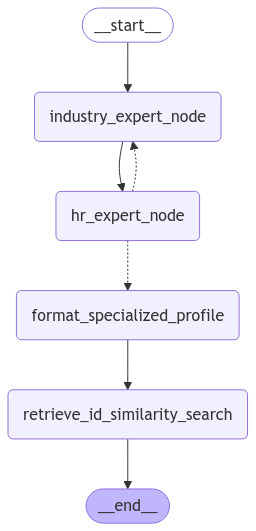

In [8]:
# Build subgraph

single_profile_builder = StateGraph(SingleProfileState)
single_profile_builder.add_node("industry_expert_node", industry_expert_node)
single_profile_builder.add_node("hr_expert_node", hr_expert_node)
single_profile_builder.add_node("format_specialized_profile", format_specialized_profile)
single_profile_builder.add_node("retrieve_id_similarity_search", retrieve_id_similarity_search)

single_profile_builder.add_edge(START, "industry_expert_node")
single_profile_builder.add_edge("industry_expert_node", "hr_expert_node")
single_profile_builder.add_conditional_edges('hr_expert_node', route_messages, ['industry_expert_node', 'format_specialized_profile'])
single_profile_builder.add_edge('format_specialized_profile', 'retrieve_id_similarity_search')
single_profile_builder.add_edge('retrieve_id_similarity_search', END)

memory = MemorySaver()
single_profile_graph = single_profile_builder.compile(checkpointer=memory).with_config(run_name="single_profile_graph")

display(Image(single_profile_graph.get_graph().draw_mermaid_png()))

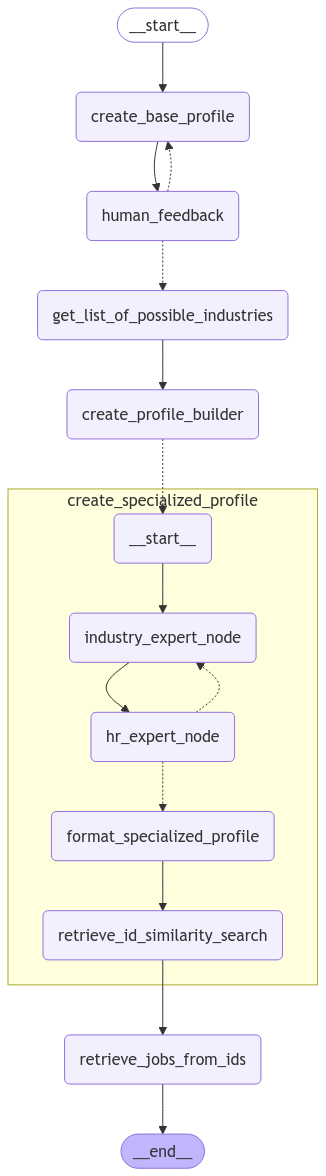

In [9]:
# Build overall graph

# Add nodes
builder = StateGraph(ProfileState)
builder.add_node("create_base_profile", create_base_profile)
builder.add_node("human_feedback", human_feedback)
builder.add_node("get_list_of_possible_industries", get_list_of_possible_industries)
builder.add_node("create_profile_builder", create_profile_builder)
builder.add_node("create_specialized_profile", single_profile_builder.compile())  # <-- rename
builder.add_node("retrieve_jobs_from_ids", retrieve_jobs_from_ids)

# Graph flow
builder.add_edge(START, "create_base_profile")
builder.add_edge("create_base_profile", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_base_profile", "get_list_of_possible_industries"])
builder.add_edge("get_list_of_possible_industries", "create_profile_builder")
builder.add_conditional_edges("create_profile_builder", spawn_specialized_profiles, ["create_specialized_profile"])
builder.add_edge("create_specialized_profile", "retrieve_jobs_from_ids")
builder.add_edge("retrieve_jobs_from_ids", END)


# Compile
memory = MemorySaver()
graph = builder.compile(#interrupt_before=["human_feedback"], 
                        checkpointer=memory)

# view
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
from backend.apps.profile_agent.llm_config import LLMFactory

ImportError: cannot import name 'LLMFactory' from 'backend.apps.profile_agent.llm_config' (c:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\backend\apps\profile_agent\llm_config.py)

In [2]:
llm.invoke('hi').content

'Hello! How can I assist you today?'

In [ ]:
from backend.apps.data_processing.process_documents import process_cv, process_cover_letter
#from src.profile_agent.agent_classes import ProfileState
from langchain_openai import ChatOpenAI
from config.settings import DATABASES
from backend.apps.profile_agent.llm_config import LLMFactory

file_paths = [r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CV_2024.pdf", r"C:\Users\TylerKleinbauer\Dropbox\Tyler\Endeavors\Scripts\Lucy\user_docs\TK_CoverLetter.pdf"]
thread = {"configurable": {"thread_id": "1"}}
llm = ChatOpenAI(model="gpt-4o")

test_state = ProfileState(
    user_docs=[process_cv(file_paths[0]), process_cover_letter(file_paths[1])],
    max_industry_experts=1,
    max_num_turns=1,
    results_to_retrieve=5,
    human_feedback=None,
    llm = LLMFactory
    chroma_path=DATABASES['job_ads_embeddings'],
    sqlite_path=DATABASES['jobs']
    )

final_state = graph.invoke(test_state, thread)

In [11]:
current_state = graph.get_state(thread)

In [12]:
current_state.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [19]:
def print_jobs(thread)
    current_state = graph.get_state(thread)
    for item in current_state.values['all_jobs']:
        print(f'Job id: {item[0]}')
        print(f'Company Name: {item[1]}')
        print(f'Job title: {item[2]} \n')
        print('Job description: \n')
        print(f'{item[3]}')
        print('-'*50)
        print('\n')

Job id: 06600420-3577-4c21-836c-ef814bef1905
Company Name: Swissquote Bank SA
Job title: Fraud Threat and Forensics Expert 

Job description: 

Building the bank of tomorrow takes more than skills.It means combining our differences to imagine, discuss, code, develop, test, learn… and celebrate every step together. Share our vibes? Join Swissquote to unleash your potential.We are the Swiss Leader in Online Banking and we provide trading, investing and banking services to+500’000 clients, through our performant and secured digital platforms.Our +1000 employees work in a flexible way, without dress code and in multicultural teams.By having a huge impact on the industry, they are growing their skills portfolio and boosting their career in a fast-pace environmentAre you all in? Don’t be shy, apply

As aFraud Threat and Forensics Analyst/Expertwithin the Middle-Office department, you will play a critical role in identifying, analyzing, and mitigating financial crime threats through advanced 

In [39]:
# from langgraph.errors import InvalidUpdateError

test = graph.invoke(current_state.values, current_state.config)

In [41]:
test.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [27]:
current_state.values

{'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPre

In [ ]:
profile = ProfileState({'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Project Management,\nPresentation Skills, Leadership,\nProblem-solving\n\n\n\n\n\nTyler      R.  Kleinbauer,            PhD\n\n\nData  Scientist and Analytics Engineer\nWORK EXPERIENCE\n\nARGUSA SA – DATA SCIENCE AND ANALYTICS ENGINEERING CONSULTANT | from 2023\nMachine Learning and Data Science:\n• Used advanced yet explainable machine learning models to predict important outcomes and enhance data analytics capabilities for a large international bank.\n• Developed two chatbots using Streamlit:\n○ Secure Data Chatbot: Securely used Retrieval Augmented Generation\n(RAG) and open-source LLMs on internal data within Snowflake.\n○ Client-facing Chatbot: Proof-of-concept RAG chatbot to answer website visitor questions using OpenAI and Huggingface APIs.\nAutomation and Data Engineering:\n• Developed a Dockerized bot on AWS and Snowflake for automated web scraping, providing daily insights and sharing summaries via Slack.\n• Streamlined data processes for a large international bank using Snowpark, automating data ingestion and error monitoring, and improving data accuracy.\nDashboards and Reporting:\n• Created role mining dashboards for the IAM department of a multinational luxury watchmaker, reducing user role creation time and enhancing compliance monitoring.\n• Led marketing initiatives, including website redesign, social media management, event organization, and creating impactful reporting tools.\nTraining and Development:\n• Conducted highly-rated training courses on Tableau and Tableau Prep, boosting participants' data visualization skills.\nUNIL – DATA SCIENTIST AND DOCTORAL RESEARCHER | 2018 – 2022\nMachine Learning and Advanced Analytics:\n• Specialized in supervised and unsupervised learning, including regression, classification, clustering, and deep learning.\n• Conducted dimensionality reduction and data preprocessing for various research projects.\nQuantitative Research:\n• Analyzed the impact of leadership on U.S. State GDP growth.\n• Evaluated ML estimator performance through Monte Carlo simulations.\nProject Leadership and Academic Contributions.\n• Led multiple research projects from inception to completion.\n• Presented research at international conferences and taught courses in\nOrganizational Behavior, Statistics for Causal Analysis, and Leadership.\n\nALAYA SA – DATA SCIENCE CONSULTANT | 2020- 2021\nData Science Strategy Development:\n• Developed strategies for data collection and analysis to assess platform impacts.\n• Identified key variables for analysis, enhancing data-driven insights.\n\nEDUCATION\nPhD in Economics - University of Lausanne\n2018 – 2022 (5.5/6 GPA)\nAwards: Rising Leaders Best Paper Award, Prix de la Solidarité Confédérale\nMaster of Science in Management - University of Lausanne\n2015 – 2017 (5/6 GPA)\n• Exchange Year - Telfer School of Management, Ottawa, Canada, 2014 – 2015 (5/6 GPA)\nBachelor of Science - University of Lausanne\n2013 – 2015 (4.7/6 GPA)",
  "À l’attention de l’équipe Talent Acquisition.\n\n\nJe suis très enthousiaste à l'idée de postuler pour le poste d’Ingénieur.e Data et Machine Learning R&I au sein du Groupe Richemont. Rita Drissi Daoudi, de l’équipe matériaux en R&I, m’ai fait part de cette\nopportunité passionnante. Mon parcours de 7 ans en Data Science et Machine Learning, allié à mon esprit entrepreneurial et à ma capacité à lier les méthodes techniques aux objectifs commerciaux, me motive à\npostuler pour ce rôle.\n\nLa force qui m’anime est une curiosité pour les nouvelles technologies et un désir d’y trouver des applications concrètes et utiles. Par exemple, j'ai initié le développement d'un bot Dockerisé déployé sur\nAWS et Snowflake pour automatiser la collecte de données via web scraping. Ce projet, né de ma propre initiative, permet de partager automatiquement des insights quotidiens de nos partenaires avec l'équipe\nArgusa via Slack. Cette expérience démontre ma capacité à innover, à travailler de manière autonome et à piloter des projets de bout en bout.\nMon intérêt pour la technologie et l'innovation ma également poussé à développer deux chatbots, l'un sécurisé, utilisant des LLMs open source sans sortie d’informations confidentielles, utilisant la ‘retrieval\naugmented generation’ (RAG) sur des données internes, et l'autre, un proof-of-concept pour les visiteurs de notre site web, utilisant les API OpenAI et Huggingface. Ces projets illustrent ma capacité à concevoir\net à déployer des solutions techniques avancées qui répondent aux besoins de l'entreprise.\n\nBien entendu, mon rôle de ‘Data Science et Analytics Engineering Consultant’ chez Argusa m’amène également à gérer des projets clients de la conception à la mise en production, assurant une livraison\noptimale des solutions, par exemple lorsque j’ai conçu et déployé en production des outils de rôle mining pour un horloger international basé à Genève.\n\nDurant mon doctorat à l'Université de Lausanne, j'ai acquis une solide expertise en Data Science et\nMachine Learning, tout en supervisant des assistants de recherche. Cette expérience m'a permis de développer des compétences en gestion de projet, d’équipe et en leadership, essentielles pour guider\ntechniquement d'autres membres de l'équipe R&I Digital Tech ML Lab.\nMon approche analytique et orientée vers les résultats m'a conduit à mettre en place des initiatives marketing chez Argusa. J'ai mené la refonte du site web, la gestion des médias sociaux et l'organisation\nd'événements, tout en créant des tableaux de bord de reporting pour évaluer le coût et le retour sur investissement. Cette démarche démontre mon œil attentif au ROI et ma capacité à aligner les efforts\ntechniques avec les objectifs commerciaux.\n\nEn rejoignant Richemont, je souhaite apporter cette même énergie entrepreneuriale et cette capacité d'innovation pour transformer vos Maisons et manufactures. Mon expertise en développement de\nsolutions de Machine Learning et mon engagement à rester à la pointe des avancées technologiques seront des atouts pour contribuer à la stratégie R&I Digital Tech ML Lab.\n\nJe serais honoré de discuter plus en détail de la manière dont je pourrais apporter ma contribution à\nRichemont et participer à l'élaboration de solutions innovantes et impactantes. Je vous remercie de l'attention portée à ma candidature et j'espère avoir l'opportunité de vous rencontrer prochainement.\n\n\nCordialement,\n\nTyler R. Kleinbauer"],
 'user_profile': UserProfile(name='Tyler R. Kleinbauer, PhD', work_experience="1. ARGUSA SA – Data Science and Analytics Engineering Consultant (from 2023)\n   - Machine Learning and Data Science:\n     • Used advanced yet explainable machine learning models to predict important outcomes and enhance data analytics capabilities for a large international bank.\n     • Developed two chatbots using Streamlit: Secure Data Chatbot (using RAG and open-source LLMs on internal data within Snowflake) and a Client-facing Chatbot (proof-of-concept RAG chatbot using OpenAI and Huggingface APIs).\n   - Automation and Data Engineering:\n     • Developed a Dockerized bot on AWS and Snowflake for automated web scraping, providing daily insights and sharing summaries via Slack.\n     • Streamlined data processes for a large international bank using Snowpark, automating data ingestion and error monitoring, and improving data accuracy.\n   - Dashboards and Reporting:\n     • Created role mining dashboards for the IAM department of a multinational luxury watchmaker, reducing user role creation time and enhancing compliance monitoring.\n     • Led marketing initiatives, including website redesign, social media management, event organization, and creating impactful reporting tools.\n   - Training and Development:\n     • Conducted highly-rated training courses on Tableau and Tableau Prep, boosting participants' data visualization skills.\n\n2. UNIL – Data Scientist and Doctoral Researcher (2018 – 2022)\n   - Machine Learning and Advanced Analytics:\n     • Specialized in supervised and unsupervised learning, including regression, classification, clustering, and deep learning.\n     • Conducted dimensionality reduction and data preprocessing for various research projects.\n   - Quantitative Research:\n     • Analyzed the impact of leadership on U.S. State GDP growth.\n     • Evaluated ML estimator performance through Monte Carlo simulations.\n   - Project Leadership and Academic Contributions:\n     • Led multiple research projects from inception to completion.\n     • Presented research at international conferences and taught courses in Organizational Behavior, Statistics for Causal Analysis, and Leadership.\n\n3. ALAYA SA – Data Science Consultant (2020-2021)\n   - Data Science Strategy Development:\n     • Developed strategies for data collection and analysis to assess platform impacts.\n     • Identified key variables for analysis, enhancing data-driven insights.", skills='Programming Languages: Python, SQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS, Dataiku, Tableau, Docker, Git\nPython Libraries: LangChain, OpenAI, NumPy, Scikit-learn, pandas, TensorFlow, Matplotlib, Keras, Selenium, Streamlit\nFrameworks: Django, React\nLanguages: English, French (native), German (beginner)\nSoft Skills: Project Management, Presentation Skills, Leadership, Problem-solving', education='PhD in Economics - University of Lausanne (2018 – 2022, 5.5/6 GPA)\n   - Awards: Rising Leaders Best Paper Award, Prix de la Solidarité Confédérale\nMaster of Science in Management - University of Lausanne (2015 – 2017, 5/6 GPA)\n   - Exchange Year - Telfer School of Management, Ottawa, Canada (2014 – 2015, 5/6 GPA)\nBachelor of Science - University of Lausanne (2013 – 2015, 4.7/6 GPA)', certifications='Snowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization', other_info='Email: tyler.kleinbauer@gmail.com\nPhone: +41 78 649 97 85\nLinkedIn: https://www.linkedin.com/in/tylerkleinbauer/'),
 'keyword_list': [],
 'selected_industries': IndustryList(selected_industries=['Consultancy']),
 'max_industry_experts': 1,
 'industry_experts': [UserProfileBuilderAssistant(name='Dr. Tyler Kleinbauer - Consultancy Expert', industry='Consultancy', description='Dr. Tyler Kleinbauer is a seasoned expert in consultancy, specializing in data science and analytics engineering. With a robust background in machine learning, data science strategies, and project leadership, Dr. Kleinbauer leverages his extensive experience working with prestigious organizations such as ARGUSA SA and ALAYA SA. His focus is on helping consultancy firms optimize their data analytics capabilities, develop automation processes, and enhance decision-making through advanced yet explainable machine learning models. Driven by a passion for innovation, Dr. Kleinbauer aims to empower consultancy firms by improving their data-driven insights and helping them stay competitive in a rapidly evolving industry. His expertise also extends to developing impactful training programs to elevate the skill sets of consultancy professionals.')],
 'llm': ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x00000231E2ED5850>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000231E300D810>, root_client=<openai.OpenAI object at 0x00000231E2ED3250>, root_async_client=<openai.AsyncOpenAI object at 0x0000023198E6BAD0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'))})

In [ ]:
import pprint
pprint.pprint(final_state)

NameError: name 'final_state' is not defined

In [20]:
all_states = [s for s in graph.get_state_history(thread)]

In [25]:
len(all_states)

6

In [29]:
pprint.pprint(all_states[0])

StateSnapshot(values={'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSoft Skills: Pro

In [32]:
for s in range(len(all_states)):
    print(f'step number {s}')
    print(all_states[s])
    print ('-'*50)

step number 0
StateSnapshot(values={'user_docs': ["PROFILE\n\nAnalytical thinker with a hybrid profile combining data science, analytics\nengineering and business administration expertise. Proven ability\nto develop innovative solutions and drive impactful projects.\nPassionate about leveraging technology to solve complex business\nproblems and improve decision- making.\n\nPERSONAL   INFO\n\nEmail:\ntyler.kleinbauer@gmail.com\nPhone:\n+41 78 649 97 85\nLinkedIn:\nhttps://www.linkedin.com/in/tylerkleinbauer/\nCERTIFICATIONS\nSnowflake SnowPro Core\nTableau Desktop Specialist\nDataIku Core Designer\nStanford Machine Learning Specialization\n\nSKILLS & TOOLS\n\nProgramming Languages: Python,\nSQL, R, Stata, JavaScript\nTools & Platforms: Snowflake, AWS,\nDataiku, Tableau, Docker. Git\nPython Libraries: LangChain, OpenAI,\nNumPy, Scikit-learn, pandas,\nTensorFlow, Matplotlib, Keras,\nSelenium. Streamlit.\nFrameworks: Django, React\nLanguages: English/French (native),\nGerman (beginner)\nSo